# Quantum MNIST

## Introduction

This notebook presents *Quantum MNIST*, a methodology for training a Quantum Neural Network (QNN) capable of classifying handwritten digits (0–9) from the MNIST dataset. The approach encodes full 28x28 input images, after a sequence of transformations, into a 22-qubit (complex) representation suitable for current quantum simulators and near-term QPUs.

The key proposals of this workflow are:
1. **Fourier-based preprocessing**  
   Each image undergoes a Fast Fourier Transform (FFT), producing complex-valued coefficients that capture spatial frequency information.

2. **Hermitian symmetry removal**  
   Since the FFT of real-valued images exhibits Hermitian symmetry, nearly half of the coefficients are redundant.  
   By explicitly removing these mirrored components, we achieve a substantial reduction in input size, directly lowering the qubit requirements.

3. **Radial subsampling**  
   From the symmetry-reduced frequency domain, only the central coefficients are retained.  
   High-frequency peripheral values are discarded due to their limited contribution to classification accuracy.  
   This results in a compact set of exactly 22 coefficients to encode.

4. **Complex dual encoding in qubits**  
   Both real and imaginary parts of each retained coefficient are embedded into the *same qubit* using a dual encoding scheme:  
   - \(Z\)-rotations represent real components.  
   - \(Y\)-rotations represent imaginary components.  
   This avoids doubling the number of qubits while preserving complete information.

5. **Custom convolution–pooling ansatz**  
   A generalized *n→1 pooling* mechanism is introduced, extending beyond traditional 2→1 pooling.  
   Groups of qubits are contracted into designated sink qubits, reducing register size and circuit depth while maintaining expressivity.  
   This makes the architecture executable on simulators and potentially on near-term quantum hardware.

The combination of these techniques produces a feasible end-to-end quantum classifier for the full MNIST problem, advancing beyond reduced or toy encodings often used in prior work.


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import z_feature_map
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
from datasets import Dataset, DatasetDict

algorithm_globals.random_seed = 12345

/home/lsjcp/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Neural Network Definition

We define the QNN as a sequence of **parameterized convolutional layers** followed by **generalized pooling layers**. These layers are designed to mimic classical convolutional neural networks (CNNs) but are adapted to the constraints of quantum computation.


### 1.1 Convolutional Layer

The convolutional block is implemented as a two-qubit parameterized circuit. It introduces local entanglement and nonlinear mixing of input features. Multiple such blocks are arranged to span all qubits in a staggered fashion, ensuring both local and global interactions.

In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

Now let's see a sample conv layer with our 22qbit design

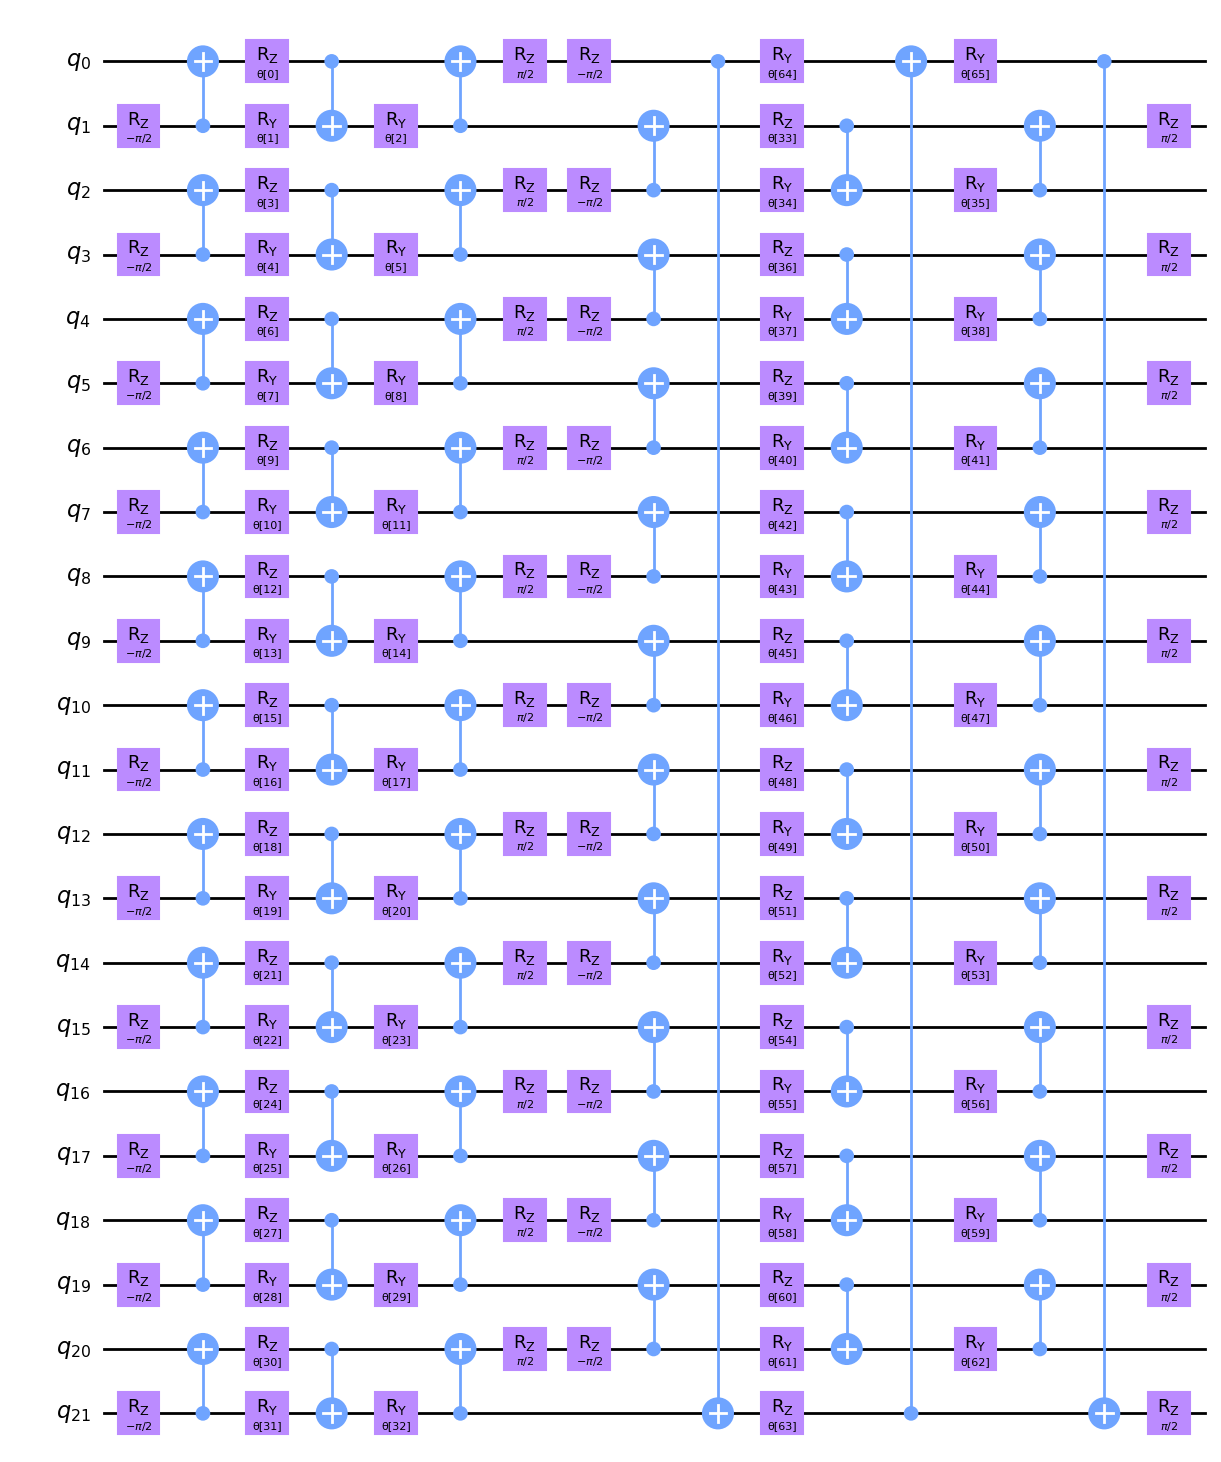

In [3]:
circuit = conv_layer(22, "θ")
circuit.decompose().draw("mpl", style="clifford")

### 1.2 Pooling Layer

In classical CNNs, pooling reduces dimensionality and enhances translational invariance. Here, we extend this concept to quantum circuits with a **generalized pooling operation**:

- Instead of being limited to 2→1 pooling, the block supports arbitrary \(n \to 1\).  
- All but one qubit in a group are discarded after entangling their information into a designated *sink qubit*.  
- This significantly reduces circuit depth and qubit requirements while retaining key correlations.


In [4]:
def generalized_pooling(num_qubits, params):
    """
    Generalized n->1 pooling block.
    All qubits [0..n-2] are pooled into qubit (n-1), the sink.
    """
    qc = QuantumCircuit(num_qubits)
    sink = num_qubits - 1
    sources = list(range(num_qubits - 1))

    # Basis change on sink (consistent with 2->1 pooling)
    qc.rz(-np.pi/2, sink)
    # Entangle sink with all sources
    for q in sources:
        qc.cx(sink, q)

    qc.barrier()

    # Local rotations on sources (discarded qubits)
    for i, q in enumerate(sources):
        qc.rz(params[i], q)

    # Initial rotation on sink
    qc.ry(params[len(sources)], sink)

    # Multi-controlled X (generalized Toffoli) from all sources into sink
    qc.mcx(sources, sink)

    # Final learnable rotation on sink
    qc.ry(params[len(sources)+1], sink)

    return qc


Now let's see a sample for a 4 to 1 pool

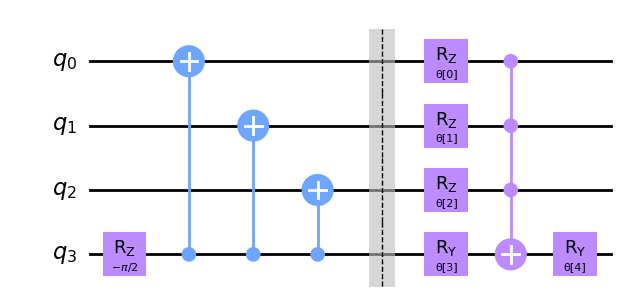

In [5]:
params = ParameterVector("θ", length=5)
circuit = generalized_pooling(4, params)
circuit.draw("mpl", style="clifford")

The following function applies pooling to predefined groups of qubits returning both the circuit and the indices of surviving sink qubits.

In [6]:
def pool_layer(pools, param_prefix):
    """ pools is a 2d array where each row will be pooled into the list qbit of the group """
    num_qubits = sum(count for count in pools)
    param_count = sum(count + 1 for count in pools)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    circuit_index = 0
    sinks = []
    params = ParameterVector(param_prefix, param_count)
    for length in pools:
        sub_param_count = length + 1
        qbit_range = range(circuit_index, circuit_index + length)
        sub_params = params[param_index : (param_index + sub_param_count)]
        sub_circuit = generalized_pooling(length, sub_params)
        qc = qc.compose(sub_circuit, qbit_range)
        #qc.barrier()
        sinks.append(circuit_index + length - 1)
        param_index += sub_param_count
        circuit_index += length
    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return [qc, sinks]


Here we will define the pooling circuit based on the desired pooling topology (([2,3,4,4,4,3,2]), in this example, the first two qbits will be pooled into one, the second pool are tree qbits that will be pooled into 1, the next tree pools have 4 bits, and so on. Notice that this resembles a semicircle that correlates with the cropped semicircular mask on the FFT of the original image after removing of the hermitian symmetry.

Sinks: [1, 4, 8, 12, 16, 19, 21]


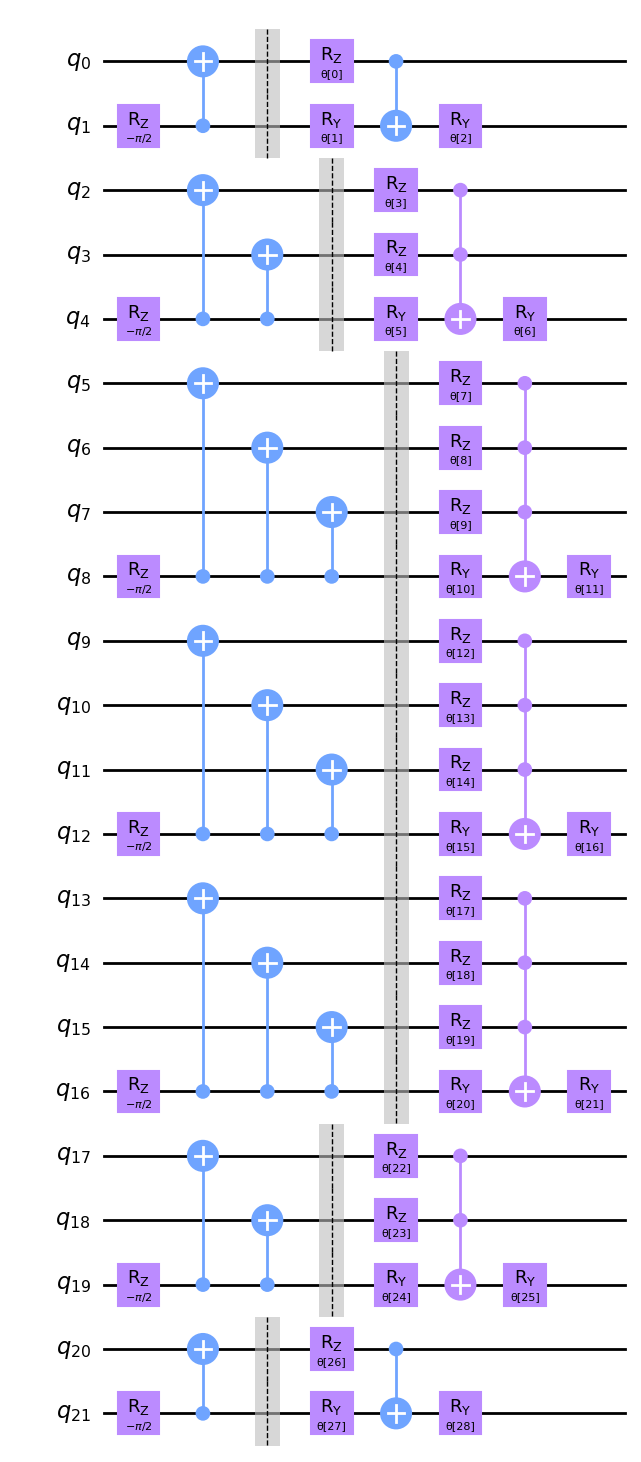

In [7]:
# Sample 22qbit pool layer with custom pooling groups
[circuit, sinks] = pool_layer([2,3,4,4,4,3,2], "θ")
print("Sinks:", sinks)
circuit.decompose().draw("mpl", style="clifford")

## 2. Loading the Quantum MNIST Dataset

A preprocessed version of MNIST, consistent with the FFT-based pipeline described above, is available as a dataset hosted on the Hugging Face Hub. Each sample contains:

- The truncated frequency-domain complex coefficients after radial subsampling.
- Metadata such as original image shape and truncation factor.
- The digit label (0–9).

We load the dataset via `pandas` to avoid Arrow index issues with JSONL files.

Check the other notebooks and code to see how to generate this dataset

In [8]:
from huggingface_hub import hf_hub_download, list_repo_files

def load_dataset_via_pandas(repo_id: str, revision: str = "main") -> DatasetDict:
    """
    Load a DatasetDict from a remote JSONL-based dataset repo on Hugging Face Hub
    using pandas as a backend to avoid ArrowIndexError.
    """
    files = list_repo_files(repo_id, repo_type="dataset", revision=revision)
    jsonl_files = [f for f in files if f.endswith(".jsonl")]

    dataset_dict = {}
    for f in jsonl_files:
        split = f.split("/")[-1].replace(".jsonl", "")
        
        local_path = hf_hub_download(repo_id, f, repo_type="dataset", revision=revision)
        
        df = pd.read_json(local_path, lines=True)
        dataset_dict[split] = Dataset.from_pandas(df, preserve_index=False)

    return DatasetDict(dataset_dict)


Loads the Quantum MNIST dataset from disk or Hugging Face Hub into memory. 
Each entry contains truncated FFT coefficients and a digit label.

In [9]:
ds = load_dataset_via_pandas("ljcamargo/quantum_mnist")

Print an example from dataset

In [10]:
print(ds["train"][0])

{'id': 'image_0000', 'label': 5, 'data': [[[None, None], [None, None], [-0.149601325392723, 0.005215304903686001], [-0.08917247503995801, -0.14660874009132302]], [[None, None], [-0.233030676841735, 0.1456268876791], [0.5733898878097531, -0.131742104887962], [-0.47518700361251803, -0.008986375294625001]], [[-0.095472157001495, 0.021066591143608003], [-0.093247435986995, -0.053984947502613005], [0.281668633222579, 0.060419723391532], [-0.17303779721260001, 0.020672706887125]], [[0.008183792233467001, -0.030594922602176004], [0.14900013804435702, 0.005881448742002001], [-0.6563084721565241, 0.045217830687761], [1.0, 0.0]], [[0.12745776772499, 0.050290331244468], [-0.23090863227844202, -0.11138548702001501], [0.126638650894165, 0.128920167684555], [-0.17303779721260001, -0.02067270129919]], [[None, None], [0.20799903571605602, 0.10138563811779001], [-0.0035532638430590003, -0.080148451030254], [-0.47518700361251803, 0.008986374363303]], [[None, None], [None, None], [0.075786158442497, -0.1

Notice that the complex "pixels" excluded by the circular mask are set as None pairs in order to preserve the matrix shape for further visualization but will be ignored while linearizing into 1D array

## 3. Visualizing Data Transformations

To understand the effect of preprocessing, we visualize:

1. The truncated complex array (real and imaginary parts).
2. The effect of restoring Hermitian symmetry.
3. The reconstruction of the original image after inverse FFT.

This comparison illustrates the degree of information retained despite aggressive subsampling, justifying the feasibility of representing MNIST images with only 22 qubits.

Notice this section is not needed for training and is just for demonstrating that the dataset represens actual MNIST Images.

In [11]:
# Helper functions for visual reconstruction
def replace_nan_pixels(arr: np.ndarray, fill_value: complex = 0+0j) -> np.ndarray:
    """
    Replace NaN+NaN pixels in a complex array with a specified fill value.
    
    Args:
        arr : np.ndarray
            Complex array with NaNs for excluded pixels.
        fill_value : complex
            Value to replace NaN pixels with.
    
    Returns:
        np.ndarray : new array with NaNs replaced.
    """
    out = arr.copy()
    mask = np.isnan(arr.real) & np.isnan(arr.imag)
    out[mask] = fill_value
    return out

# Helper function to get topology from 2D array excluding empty pixels
def get_topology_from_array(array):
    return [len([item for item in row if item != [None, None]]) for row in array]

In [12]:
row = ds["train"][0]
row_data = row["data"]

# Transposing the row data to match the expected format
row_data = [[row[i] for row in row_data] for i in range(len(row_data[0]))]

raw_complex_array = np.array([
    [
        complex(r if r is not None else np.nan, i if i is not None else np.nan)
        for r, i in row
    ]
    for row in row_data
])
raw_complex_array = raw_complex_array.T
topology = get_topology_from_array(row_data)
complex_array = replace_nan_pixels(np.array(raw_complex_array))
print("Topology", topology)
print("Real")
print(np.real(complex_array))
print("Imaginary")
print(np.imag(complex_array))

Topology [3, 5, 7, 7]
Real
[[ 0.          0.         -0.14960133 -0.08917248]
 [ 0.         -0.23303068  0.57338989 -0.475187  ]
 [-0.09547216 -0.09324744  0.28166863 -0.1730378 ]
 [ 0.00818379  0.14900014 -0.65630847  1.        ]
 [ 0.12745777 -0.23090863  0.12663865 -0.1730378 ]
 [ 0.          0.20799904 -0.00355326 -0.475187  ]
 [ 0.          0.          0.07578616 -0.08917249]]
Imaginary
[[ 0.          0.          0.0052153  -0.14660874]
 [ 0.          0.14562689 -0.1317421  -0.00898638]
 [ 0.02106659 -0.05398495  0.06041972  0.02067271]
 [-0.03059492  0.00588145  0.04521783  0.        ]
 [ 0.05029033 -0.11138549  0.12892017 -0.0206727 ]
 [ 0.          0.10138564 -0.08014845  0.00898637]
 [ 0.          0.         -0.10029694  0.14660874]]


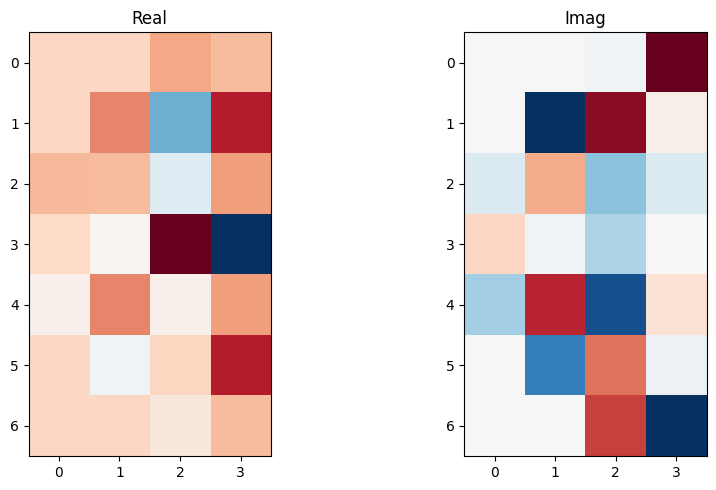

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.real(complex_array), cmap='RdBu')
axes[0].set_title('Real')
axes[1].imshow(np.imag(complex_array), cmap='RdBu')
axes[1].set_title('Imag')

plt.tight_layout()
plt.show()

Now let's restore the Hermitian Symmetry and untruncate to show how the image would look if original size was restored. This will depict how the compression proposed would impact on the perception of the image

In [14]:
import math

def restore_hermitian(truncated, original_shape):
    h, w = original_shape
    restored = np.zeros((h, w), dtype=truncated.dtype)
    restored[:, :truncated.shape[1]] = truncated
    
    truncated_w = truncated.shape[1]
    offset = 0 if w % 2 == 0 else -1 
    start_j = truncated_w + offset
    for j in range(1, start_j+1):
        restored[:, w - j] = np.conj(restored[::-1, j-1])
    
    return restored

def untruncate_fft(truncated, original_shape):
    """Untruncate FFT data back to original shape"""
    h, w = original_shape
    padded = np.zeros(original_shape, dtype=np.complex64)
    
    th, tw = truncated.shape
    top = math.ceil((h - th) / 2)
    left = math.ceil((w - tw) / 2)
    
    padded[top:top + th, left:left + tw] = truncated
    return padded

In [15]:
truncated_shape = np.floor(np.array(row['original_shape']) * row['truncate_factor']).astype(int)
restored_hermitian = restore_hermitian(complex_array, truncated_shape)
restored_untruncated = untruncate_fft(restored_hermitian, row['original_shape'])
restored_unfft = np.fft.ifftn(np.fft.ifftshift(restored_untruncated), norm='forward')

print("Original MNIST Shape", row['original_shape'])
print("Truncated Shape", truncated_shape)

Original MNIST Shape [28, 28]
Truncated Shape [7 7]


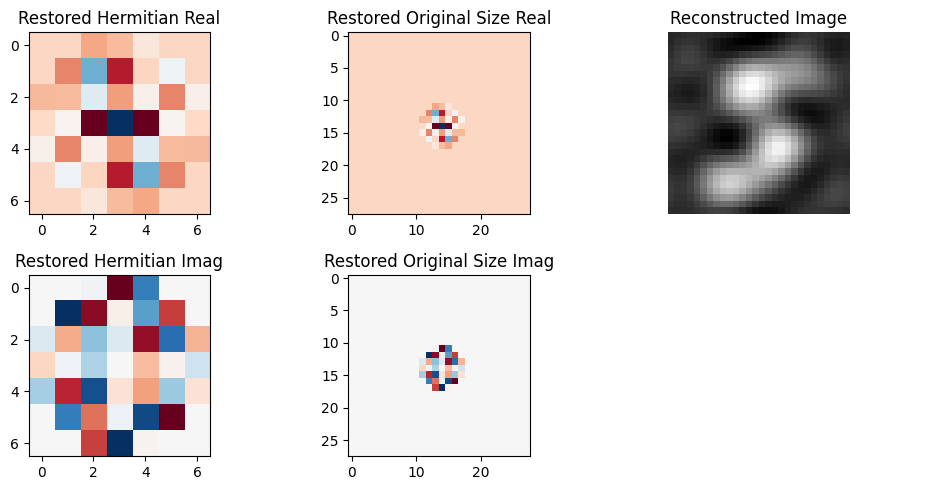

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes[0,0].imshow(np.real(restored_hermitian), cmap='RdBu')
axes[0,0].set_title('Restored Hermitian Real')
axes[1,0].imshow(np.imag(restored_hermitian), cmap='RdBu')
axes[1,0].set_title('Restored Hermitian Imag')

axes[0,1].imshow(np.real(restored_untruncated), cmap='RdBu')
axes[0,1].set_title('Restored Original Size Real')
axes[1,1].imshow(np.imag(restored_untruncated), cmap='RdBu')
axes[1,1].set_title('Restored Original Size Imag')

axes[0, 2].imshow(np.real(restored_unfft), cmap='gray')
axes[0, 2].set_title('Reconstructed Image')
axes[0, 2].axis('off')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 4. Encoding Complex Arrays into Quantum Circuits

Each non-excluded FFT coefficient corresponds to a qubit. Both real and imaginary parts are embedded as rotation angles:

- \(Z\)-rotations encode real components.
- \(Y\)-rotations encode imaginary components.

This dual encoding ensures that both magnitude and phase information are preserved without doubling the qubit count.


Let's get the rows and columns and then linearize our complex array, in this example altough the array has 4x7 shape = 28qbits, the pixels that lay outside the circle are also excluded, that why in the dataset they are stored as None values, so we only be embedding the shape tensor minus the excluded (4*7) - 6 = 22qubits and we will flatten this sequentially skipping null values.

In [17]:
print("Original Array with nan+naj corresponding to excluded qbits\n", raw_complex_array)

Original Array with nan+naj corresponding to excluded qbits
 [[        nan       +nanj         nan       +nanj -0.14960133+0.0052153j
  -0.08917248-0.14660874j]
 [        nan       +nanj -0.23303068+0.14562689j  0.57338989-0.1317421j
  -0.475187  -0.00898638j]
 [-0.09547216+0.02106659j -0.09324744-0.05398495j  0.28166863+0.06041972j
  -0.1730378 +0.02067271j]
 [ 0.00818379-0.03059492j  0.14900014+0.00588145j -0.65630847+0.04521783j
   1.        +0.j        ]
 [ 0.12745777+0.05029033j -0.23090863-0.11138549j  0.12663865+0.12892017j
  -0.1730378 -0.0206727j ]
 [        nan       +nanj  0.20799904+0.10138564j -0.00355326-0.08014845j
  -0.475187  +0.00898637j]
 [        nan       +nanj         nan       +nanj  0.07578616-0.10029694j
  -0.08917249+0.14660874j]]


Let's flatten into 1d array of complex items but removing the empty values

In [18]:
raw_complex_array = raw_complex_array.T # <- Transpose
print("Shape of the array", raw_complex_array.shape)

[w, h] = raw_complex_array.shape

# flatten
flat = raw_complex_array.flatten()
print("Flatened 1d array size", flat.shape)
# filter out "null" complex numbers (both real and imag are nan)
flat_filtered = flat[~(np.isnan(flat.real) & np.isnan(flat.imag))]
print("Flatened 1d array size minus Nan", flat_filtered.shape)
print("\nOriginal\n", raw_complex_array)
print("\nFlattened Array minus Nan\n", flat_filtered)

Shape of the array (4, 7)
Flatened 1d array size (28,)
Flatened 1d array size minus Nan (22,)

Original
 [[        nan       +nanj         nan       +nanj -0.09547216+0.02106659j
   0.00818379-0.03059492j  0.12745777+0.05029033j         nan       +nanj
          nan       +nanj]
 [        nan       +nanj -0.23303068+0.14562689j -0.09324744-0.05398495j
   0.14900014+0.00588145j -0.23090863-0.11138549j  0.20799904+0.10138564j
          nan       +nanj]
 [-0.14960133+0.0052153j   0.57338989-0.1317421j   0.28166863+0.06041972j
  -0.65630847+0.04521783j  0.12663865+0.12892017j -0.00355326-0.08014845j
   0.07578616-0.10029694j]
 [-0.08917248-0.14660874j -0.475187  -0.00898638j -0.1730378 +0.02067271j
   1.        +0.j         -0.1730378 -0.0206727j  -0.475187  +0.00898637j
  -0.08917249+0.14660874j]]

Flattened Array minus Nan
 [-0.09547216+0.02106659j  0.00818379-0.03059492j  0.12745777+0.05029033j
 -0.23303068+0.14562689j -0.09324744-0.05398495j  0.14900014+0.00588145j
 -0.23090863-0.11138

Now we can get the final amount of qbits that will be used

In [19]:
circuit_size = len(flat_filtered)
print("Qbit length", circuit_size)

Qbit length 22


The following cell constructs a parameterized quantum circuit by applying RZ and RY rotations corresponding to real and imaginary FFT components.

In [20]:
from qiskit.circuit import QuantumCircuit, Parameter

def create_complex_feature_map(qbit_count):
    n_features = qbit_count * 2
    qc = QuantumCircuit(qbit_count)
    
    # Create parameters for real and imaginary parts
    all_params = [
        Parameter(
            f'{i:03d}'
        ) for i in range(n_features)
    ]
    
    for i in range(qbit_count):
        current_param = i * 2
        qc.rz(2 * all_params[current_param], i)
        qc.ry(2 * all_params[current_param + 1], i)
    
    return qc

Let's see a 5qbit embedding circuit sample

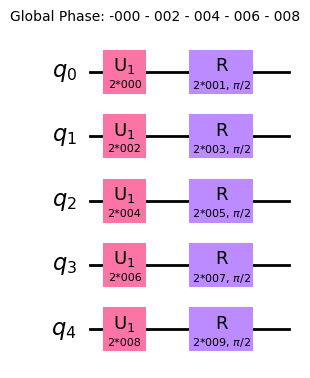

In [21]:
feature_map = create_complex_feature_map(qbit_count=5)
feature_map.decompose().draw("mpl", style="clifford")

And let's print the params

In [22]:
print("Map params", feature_map.parameters)

Map params ParameterView([Parameter(000), Parameter(001), Parameter(002), Parameter(003), Parameter(004), Parameter(005), Parameter(006), Parameter(007), Parameter(008), Parameter(009)])


## 5. Training Pipeline

The full QNN consists of:

1. **Feature map** – encodes complex input features.  
2. **Ansatz** – a sequence of convolutional and pooling layers.  
3. **Measurement observables** – constructed to project onto class subspaces.

We employ the `EstimatorQNN` interface in Qiskit and train using SPSA optimization. To monitor convergence, a callback function records and plots the loss function while optionally checkpointing weights.


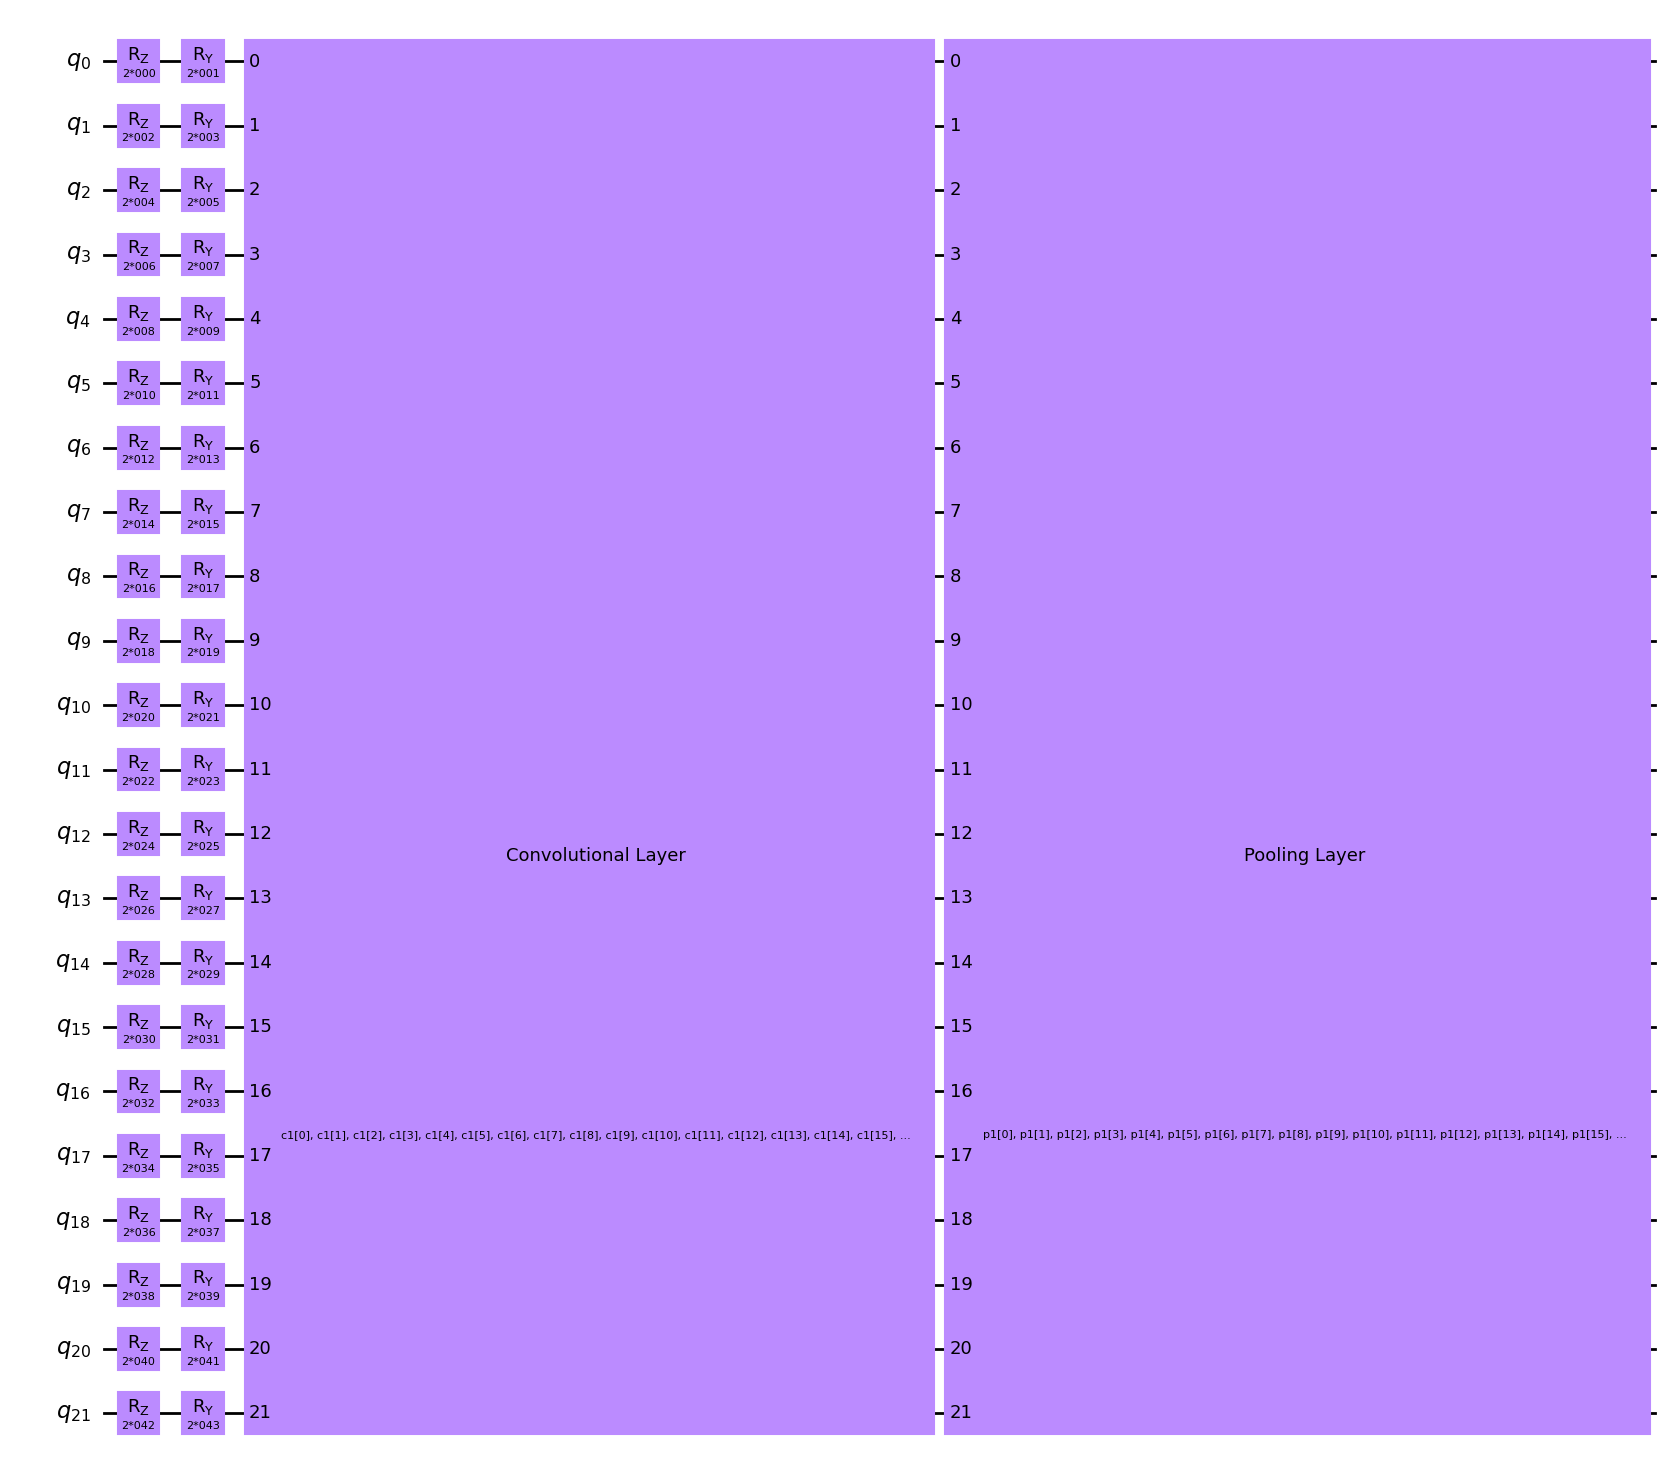

In [23]:
feature_map = create_complex_feature_map(qbit_count=circuit_size)
feature_map.draw("mpl", style="clifford")

ansatz = QuantumCircuit(circuit_size, name="Ansatz")

# First Convolutional Layer
convolution = conv_layer(circuit_size, "c1")
ansatz.compose(convolution, list(range(circuit_size)), inplace=True)

# First Pooling Layer
[pool, sinks] = pool_layer(topology, "p1")
ansatz.compose(pool, list(range(circuit_size)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(circuit_size, name="QNN Circuit")
circuit.compose(feature_map, range(circuit_size), inplace=True)
circuit.compose(ansatz, range(circuit_size), inplace=True)

circuit.draw("mpl", style="clifford")

Specify the last sink qbits as observables by transforming to Pauli String (mind the big endian qiskit convention)

In [24]:
from qiskit.quantum_info import SparsePauliOp

def number_operator_from_indices(n_qubits, bit_indices, weights=None):
    """
    Build N = sum_k weights[k] * (I - Z(bit_indices[k]))/2
    - n_qubits: total number of qubits in the circuit
    - bit_indices: list of qubit indices that carry the result
                   (ordered LSB -> MSB)
    - weights: optional list of the same length; defaults to powers of 2
               [1, 2, 4, ...] in that LSB->MSB order
    """
    if weights is None:
        weights = [2**k for k in range(len(bit_indices))]

    paulis, coeffs = [], []

    for q, w in zip(bit_indices, weights):
        # + (w/2) * I...I
        paulis.append("I" * n_qubits)
        coeffs.append(w / 2)

        # - (w/2) * ...Z...
        z = ["I"] * n_qubits
        # Qiskit Pauli string order is MSB..LSB (left->right),
        # so put Z at position (n_qubits - 1 - q)
        z[n_qubits - 1 - q] = "Z"
        paulis.append("".join(z))
        coeffs.append(-w / 2)

    op = SparsePauliOp.from_list(list(zip(paulis, coeffs))).simplify()
    return op

def class_projector_observable(n_qubits, output_qubits, class_label):
    """
    Create a projector observable |class_label><class_label| on output_qubits
    - n_qubits: total qubits in circuit
    - output_qubits: list of qubit indices (LSB -> MSB)
    - class_label: integer, e.g., 0..9
    """
    binary = np.array(list(np.binary_repr(class_label, width=len(output_qubits))), dtype=int)
    # convert '0'/'1' to int array
    paulis = ["I"] * n_qubits
    coeff = 1.0

    # Start with coefficient 1 and multiply (I ± Z)/2 per bit
    terms = [("I"*n_qubits, 1.0)]  # initial term

    for qubit_idx, bit_val in zip(output_qubits, binary[::-1]):  # LSB->MSB
        new_terms = []
        for s, c in terms:
            # choose I+Z or I-Z
            s_list = list(s)
            s_list[n_qubits - 1 - qubit_idx] = "I"
            c_i = c * 0.5
            new_terms.append(("".join(s_list), c_i))
            
            s_list_z = list(s)
            s_list_z[n_qubits - 1 - qubit_idx] = "Z"
            c_z = c * (0.5 * (-1 if bit_val==1 else 1))
            new_terms.append(("".join(s_list_z), c_z))
        terms = new_terms

    # combine terms with same Pauli string
    from collections import defaultdict
    term_dict = defaultdict(float)
    for s, c in terms:
        term_dict[s] += c

    op = SparsePauliOp.from_list(list(term_dict.items())).simplify()
    return op

Example: 22 qubits, "output" qubits at [2,7,14,21], class 3

In [25]:
class_projector_observable(22, [2,7,14,21], 0)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIII', 'ZIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIZIIIIIII', 'ZIIIIIIZIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIZIIIIIIIIIIIZII', 'ZIIIIIIZIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZIIIIZII', 'ZIIIIIIIIIIIIIZIIIIZII', 'IIIIIIIZIIIIIIZIIIIZII', 'ZIIIIIIZIIIIIIZIIIIZII'],
              coeffs=[0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j])

Defines the training routine with SPSA optimizer, using callbacks to track loss and save intermediate weights.

In [26]:
from qiskit_aer.primitives import EstimatorV2

class_count = 10
observables = [class_projector_observable(circuit_size, sinks, k) for k in range(class_count)]
options = {
    "backend_options": {
        "method": "statevector",          # exact simulation
        "max_parallel_threads": 20,        # multi-thread CPU
    },
    "run_options": {
        "shots": 0                        # statevector -> no shots
    },
    "default_precision": 0.0
}
estimator = EstimatorV2(options=options)

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observables,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [27]:
objective_func_vals = []
weights_history = []

def callback_graph(weights, obj_func_eval, 
                   checkpoint_interval=5, 
                   filename_obj="objective_values.json",
                   filename_weights="weights_checkpoint.json",
                   save_weights=True):
    """
    Original callback with optional JSON checkpointing.

    Args:
        weights: current optimizer parameters
        obj_func_eval: current objective function value
        checkpoint_interval: save weights every N iterations (default=5)
        filename_obj: file to store objective values (default="objective_values.json")
        filename_weights: file to store weights (default="weights_checkpoint.json")
        save_weights: whether to save weights (default=True)
    """
    # Append objective value
    objective_func_vals.append(obj_func_eval)
    
    # Save objective values every iteration
    with open(filename_obj, "w") as f:
        json.dump(objective_func_vals, f, indent=2)
    
    # Save weights every `checkpoint_interval` steps if enabled
    if save_weights:
        weights_history.append(weights.tolist() if hasattr(weights, "tolist") else list(weights))
        if len(weights_history) % checkpoint_interval == 0:
            with open(filename_weights, "w") as f:
                json.dump(weights_history, f, indent=2)
    
    # Plot objective function
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(range(len(objective_func_vals)), objective_func_vals, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.title("Objective function value vs Iteration")
    plt.grid(True)
    plt.show()


def callback_step(evaluations, parameters, loss, stepsize, accepted):
    print(f"Step {evaluations}: Loss = {loss:.6f}, Stepsize = {stepsize:.6f}, Accepted = {accepted}")


In [28]:
MAX_ITERS = 30
SAMPLES = 30

In [29]:
# Scheduler for learning rate and perturbation
def make_schedule(init=0.2, decay=0.99):
        def generator():
            i = 0
            while True:
                yield init * (decay**i)
                i += 1
        return generator

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(
        maxiter=MAX_ITERS, 
        learning_rate = make_schedule(init=0.2, decay=0.99), 
        perturbation = make_schedule(init=0.1, decay=0.99),
        callback=callback_step,
    ),
    callback=callback_graph,
)

## 6. Dataset Preparation for Training

For training, each preprocessed sample is flattened into a one-dimensional feature vector like this:

[[real0, imag0],[real1, imag1],[real2, imag2]] = [real0, imag0, real1, imag1, real2, imag2] 

Labels remain unchanged as integer class identifiers (0–9) as labels are already classes indexes as in this premise (MNIST) images depicting a zero will be of class 0. So no mapping is needed.


In [30]:
def process_item(item):
    data = item["data"]
    # Transpose
    data = [[row[i] for row in data] for i in range(len(data[0]))]
    # Remove Nones
    data = [[pair for pair in row if pair[0]] for row in data]
    # Flatten
    data = [value for row in data for pair in row for value in pair]
    return {
        "features": data,
        "label": item["label"]
    }

Sample processed item

In [31]:
process_item(ds["train"][0])

{'features': [-0.095472157001495,
  0.021066591143608003,
  0.008183792233467001,
  -0.030594922602176004,
  0.12745776772499,
  0.050290331244468,
  -0.233030676841735,
  0.1456268876791,
  -0.093247435986995,
  -0.053984947502613005,
  0.14900013804435702,
  0.005881448742002001,
  -0.23090863227844202,
  -0.11138548702001501,
  0.20799903571605602,
  0.10138563811779001,
  -0.149601325392723,
  0.005215304903686001,
  0.5733898878097531,
  -0.131742104887962,
  0.281668633222579,
  0.060419723391532,
  -0.6563084721565241,
  0.045217830687761,
  0.126638650894165,
  0.128920167684555,
  -0.0035532638430590003,
  -0.080148451030254,
  0.075786158442497,
  -0.100296944379806,
  -0.08917247503995801,
  -0.14660874009132302,
  -0.47518700361251803,
  -0.008986375294625001,
  -0.17303779721260001,
  0.020672706887125,
  1.0,
  0.0,
  -0.17303779721260001,
  -0.02067270129919,
  -0.47518700361251803,
  0.008986374363303,
  -0.08917248994112001,
  0.14660874009132302],
 'label': 5}

Now let's flatten each sample into alternating real/imaginary values and prepares integer labels for supervised learning.

In [32]:
processed_ds = ds["train"].select(range(SAMPLES)).map(process_item)
features = [sample["features"] for sample in processed_ds]
labels = [sample["label"] for sample in processed_ds]

print("Sample features at 0:", features[0])
print("Sample label at 0:", labels[0])

Map: 100%|██████████| 30/30 [00:00<00:00, 861.99 examples/s]

Sample features at 0: [-0.095472157001495, 0.021066591143608003, 0.008183792233467001, -0.030594922602176004, 0.12745776772499, 0.050290331244468, -0.233030676841735, 0.1456268876791, -0.093247435986995, -0.053984947502613005, 0.14900013804435702, 0.005881448742002001, -0.23090863227844202, -0.11138548702001501, 0.20799903571605602, 0.10138563811779001, -0.149601325392723, 0.005215304903686001, 0.5733898878097531, -0.131742104887962, 0.281668633222579, 0.060419723391532, -0.6563084721565241, 0.045217830687761, 0.126638650894165, 0.128920167684555, -0.0035532638430590003, -0.080148451030254, 0.075786158442497, -0.100296944379806, -0.08917247503995801, -0.14660874009132302, -0.47518700361251803, -0.008986375294625001, -0.17303779721260001, 0.020672706887125, 1.0, 0.0, -0.17303779721260001, -0.02067270129919, -0.47518700361251803, 0.008986374363303, -0.08917248994112001, 0.14660874009132302]
Sample label at 0: 5


## 7. Resource Estimation

Quantum circuits must be evaluated not only for accuracy but also for feasibility on simulators and hardware. We therefore compute:

- Number of qubits.  
- Circuit depth.  
- Gate counts and parameter counts.  
- Memory requirements for statevector simulation.  
- Approximate runtime estimates based on observables and sample size.

These metrics provide a practical assessment of whether the proposed QNN can be executed on available platforms.

In [33]:
def circuit_stats(circuit: QuantumCircuit, observables=None):
    """
    Print useful statistics for a QuantumCircuit to estimate resources and runtime.
    
    Parameters:
        circuit : QuantumCircuit
            The circuit to analyze.
        observables : list or SparsePauliOp, optional
            List of observables or a single observable to estimate number of Pauli terms.
    """
    print("===== Circuit Statistics =====")
    
    # Number of qubits
    n_qubits = circuit.num_qubits
    print("Number of qubits:", n_qubits)
    
    # Circuit depth
    depth = circuit.depth()
    print("Circuit depth:", depth)
    
    # Total number of instructions / gates
    instr_count = len(circuit.data)
    print("Total instructions in circuit:", instr_count)
    
    # Gate counts
    gate_count = circuit.count_ops()
    print("Gate counts:", gate_count)
    
    # Number of parameters
    param_count = len(circuit.parameters)
    print("Number of parameters:", param_count)
    
    # Estimated statevector memory
    mem_bytes = 2**n_qubits * 16  # complex128 = 16 bytes
    mem_mb = mem_bytes / 1024**2
    print(f"Estimated statevector memory: {mem_mb:.1f} MB")
    
    # Observables info
    if observables is not None:
        if hasattr(observables, "__len__") and not isinstance(observables, (str, QuantumCircuit)):
            num_observables = len(observables)
            total_pauli_terms = sum(len(o) for o in observables)
        else:  # single observable
            num_observables = 1
            total_pauli_terms = len(observables)
        print("Number of observables:", num_observables)
        print("Total number of Pauli terms:", total_pauli_terms)
    
    print("==============================")


In [34]:
circuit_stats(circuit.decompose(), observables)

===== Circuit Statistics =====
Number of qubits: 22
Circuit depth: 26
Total instructions in circuit: 276
Gate counts: OrderedDict([('rz', 88), ('cx', 84), ('ry', 52), ('u1', 22), ('r', 22), ('barrier', 4), ('mcx', 3), ('ccx', 1)])
Number of parameters: 136
Estimated statevector memory: 64.0 MB
Number of observables: 10
Total number of Pauli terms: 160


In [35]:
def estimate_runtime(circuit, observables, n_samples=1, device='cpu'):
    """
    Rough estimate of runtime for simulating a circuit with given observables.

    Parameters:
        circuit : QuantumCircuit
            The circuit to analyze.
        observables : list or SparsePauliOp
            List of observables or single observable.
        n_samples : int
            Number of input samples to evaluate.
        device : str
            'cpu' or 'gpu' to scale estimate.

    Returns:
        None (prints estimated time)
    """
    n_qubits = circuit.num_qubits
    depth = circuit.depth()
    
    # Handle observables
    if hasattr(observables, "__len__") and not isinstance(observables, (str, QuantumCircuit)):
        total_terms = sum(len(o) for o in observables)
        num_observables = len(observables)
    else:
        total_terms = len(observables)
        num_observables = 1

    # Base time per Pauli term per sample (rough)
    # These are empirical approximations for statevector simulation
    base_ms = 10  # ms per term for shallow circuit on CPU
    # scale linearly with depth relative to a “unit” depth 4
    base_ms *= depth / 4  

    # Scale for GPU
    if device.lower() == 'gpu':
        base_ms /= 5  # assume ~5x speedup

    # Total per sample
    time_per_sample_sec = total_terms * base_ms / 1000  # ms → sec

    # Total for all samples
    total_time_sec = n_samples * time_per_sample_sec

    print("===== Runtime Estimate =====")
    print(f"Circuit depth: {depth}")
    print(f"Number of qubits: {n_qubits}")
    print(f"Number of observables: {num_observables}")
    print(f"Total Pauli terms: {total_terms}")
    print(f"Number of samples: {n_samples}")
    print(f"Estimated time per sample: {time_per_sample_sec:.2f} sec")
    print(f"Estimated total time: {total_time_sec:.2f} sec ≈ {total_time_sec/60:.2f} min")
    print("============================")


**Warning** the estimated times are currently broken actual estimates are being calculated empirically

In [36]:
estimate_runtime(circuit.decompose(), observables, n_samples=10, device='cpu')

===== Runtime Estimate =====
Circuit depth: 26
Number of qubits: 22
Number of observables: 10
Total Pauli terms: 160
Number of samples: 10
Estimated time per sample: 10.40 sec
Estimated total time: 104.00 sec ≈ 1.73 min


## 8. Training the Quantum CNN

At this stage we fit the classifier on the preprocessed dataset.  
This step is computationally the most expensive part of the workflow:

- Even with the toy example of **30 iterations**, training may take extensive runtime and significant memory resources.  
- The cost grows with the number of qubits, parameters, and SPSA iterations.  
- When running on simulators (statevector or shot-based), expect long execution times, especially on consumer-grade hardware.

It is strongly recommended to begin with small subsets of the dataset and very few iterations to verify correctness before scaling up.

In [ ]:
x = np.asarray(features)
y = np.asarray(labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

NeuralNetworkClassifier._fit_internal called
NeuralNetworkClassifier._fit_internal validated input
NeuralNetworkClassifier._fit_internal created objective function
NeuralNetworkClassifier._minimize called
NeuralNetworkClassifier._minimize got objective function
NeuralNetworkClassifier._minimize using Optimizer
Using provided SPSA parameters.
SPSA: Initializing optimization.
SPSA: Starting optimization.
SPSA: Iteration %s/%s. 1 31
SPSA: Iteration %s/%s done in %s. 1 31 176.99609470367432


## 9. Inference and Testing

Once trained, the QNN can be evaluated on unseen data.  
Here we select a small set of MNIST samples outside the training indices and predict their labels.  

This step provides:

- **Test accuracy** on new examples.  
- A direct comparison of predicted vs true labels.

Note: The performance reported here is illustrative, given the limited iterations and small dataset. Scaling to full MNIST or higher iteration counts would require substantially more computational resources.

In [ ]:
# Selects a small slice of MNIST samples (indices 100–110) 
# and preprocesses them with the same FFT pipeline.

test_ds = ds["train"].select(range(100, 110)).map(process_item)
test_features = [sample["features"] for sample in test_ds]
test_labels = [sample["label"] for sample in test_ds]

Map: 100%|██████████| 10/10 [00:00<00:00, 1824.32 examples/s]


In [ ]:
# Prints the true labels of the selected test samples.
test_labels

[5, 7, 1, 7, 1, 1, 6, 3, 0, 2]

In [ ]:
# Runs inference using the trained classifier on test features.
# Reports accuracy, predicted labels, and ground-truth labels side by side.

y_predict = classifier.predict(test_features)
x = np.asarray(test_features)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")
print("Predicted labels:", y_predict)
print("True labels:", y)


Accuracy from the test data : 10.0%
Predicted labels: [3 3 3 3 3 3 2 3 3 7]
True labels: [5 7 1 7 1 1 6 3 0 2]


## 10. Conclusion and Future Work

This notebook introduced *Quantum MNIST*, a complete pipeline for encoding, training, and evaluating a quantum neural network on the MNIST dataset. The methodology combined:

- Fourier-based preprocessing with radial subsampling, reducing each image to 22 significant coefficients.  
- Dual real–imaginary embedding into qubits through \(Z\) and \(Y\) rotations.  
- Convolutional layers inspired by classical CNNs but realized as parameterized two-qubit circuits.  
- A novel **generalized pooling** scheme (n→1), reducing qubits while maintaining expressivity.  
- End-to-end training with Qiskit’s `EstimatorQNN` and SPSA optimization.  

Currently, the training using the full MNIST dataset is ongoing and remains under active experimentation.  
Results are expected soon, and further analysis will be added once sufficient training iterations and evaluations have been completed.

This notebook therefore represents the methodology and experimental setup, while performance benchmarks and conclusions are pending.
